# Numpy Exercises

### Exercise 1
Consider the polynomial expression
$$p(x) = a_0+a_1x + a_2x^2 + \cdots + a_Nx^N = \sum_{n=N}^n a_nx^n$$
Earlier, you wrote a simple function p(x, coeff) to evaluate (1.2) without considering efficiency    
Now write a new function that does the same job, but uses NumPy arrays and array operations for its computations, rather than any form of Python loop    
(Such functionality is already implemented as np.poly1d, but for the sake of the exercise don’t use this class)    
• Hint: Use np.cumprod()    

**Solution**

This code does the job

In [4]:
import numpy as np

def p(x, coef):
    X = np.empty(len(coef))
    X[0] = 1
    X[1:] = x
    y = np.cumprod(X)   # y = [1, x, x**2,...]
    return coef @ y

Let’s test it

In [5]:
coef = np.ones(3)
print(coef)
print(p(1, coef))
# For comparison
q = np.poly1d(coef)
print(q(1))

[ 1.  1.  1.]
3.0
3.0


### Exercise 2
Let q be a NumPy array of length n with q.sum() == 1    
Suppose that q represents a probability mass function    
We wish to generate a discrete random variable 𝑥 such that P{𝑥 = 𝑖} = $𝑞_𝑖$     
In other words, x takes values in range(len(q)) and x = i with probability q[i]    
The standard (inverse transform) algorithm is as follows:    
• Divide the unit interval [0, 1] into 𝑛 subintervals $𝐼_0, 𝐼_1, . . . , 𝐼_{𝑛−1}$ such that the length of $𝐼_𝑖 $is $𝑞_𝑖$    
• Draw a uniform random variable 𝑈 on [0, 1] and return the 𝑖 such that 𝑈 ∈ $𝐼_𝑖 $    
The probability of drawing 𝑖 is the length of$𝐼_𝑖 $, which is equal to  $𝑞_𝑖$     
We can implement the algorithm as follows

In [95]:
from random import uniform
def sample(q):
    a = 0.0
    U = uniform(0, 1)
    for i in range(len(q)):
        if a < U <= a + q[i]:
            return i
        a = a + q[i]

If you can’t see how this works, try thinking through the flow for a simple example, such as q = [0.25, 0.75] It helps to sketch the intervals on paper
Your exercise is to speed it up using NumPy, avoiding explicit loops  
• Hint: Use np.searchsorted and np.cumsum If you can, implement the functionality as a class called discreteRV, where  
• the data for an instance of the class is the vector of probabilities q • the class has a draw() method, which returns one draw according to the algorithm described above
If you can, write the method so that draw(k) returns k draws from q

**Solution**

Here’s our first pass at a solution:

In [6]:
from numpy import cumsum
from numpy.random import uniform

class discreteRV:
    """
    Generates an array of draws from a discrete random variable with vector of
    probabilities given by q.
    """

    def __init__(self, q):
        """
        The argument q is a NumPy array, or array like, nonnegative and sums
        to 1
        """
        self.q = q
        self.Q = cumsum(q)

    def draw(self, k=1):
        """
        Returns k draws from q. For each such draw, the value i is returned
        with probability q[i].
        """
        return self.Q.searchsorted(uniform(0, 1, size=k))

The logic is not obvious, but if you take your time and read it slowly, you will understand  
There is a problem here, however  
Suppose that q is altered after an instance of $discreteRV$ is created, for example by

In [7]:
q = (0.1, 0.9)
d = discreteRV(q)
d.q = (0.5, 0.5)

The problem is that Q does not change accordingly, and Q is the data used in the draw method

To deal with this, one option is to compute Q every time the draw method is called

But this is inefficient relative to computing Q once off

A better option is to use descriptors

A solution from the [quantecon library](https://github.com/QuantEcon/QuantEcon.py/tree/master/quantecon) using descriptors that behaves as we desire can be found [here](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/discrete_rv.py)

 
### Exercise 3
Recall our [earlier discussion](https://lectures.quantecon.org/py/python_oop.html#id8) of the empirical cumulative distribution function    
Your task is to    
1. Make the $__call__$ method more efficient using NumPy    
2. Add a method that plots the ECDF over [𝑎, 𝑏], where 𝑎 and 𝑏 are method parameters

**Solution**  
An example solution is given below.

In essence we’ve just taken this code from QuantEcon and added in a plot method

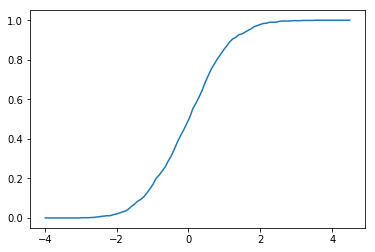

In [17]:
#Modifies ecdf.py from QuantEcon to add in a plot method
import numpy as np
import matplotlib.pyplot as plt

class ECDF:
    """
    One-dimensional empirical distribution function given a vector of
    observations.

    Parameters
    ----------
    observations : array_like
        An array of observations

    Attributes
    ----------
    observations : array_like
        An array of observations

    """

    def __init__(self, observations):
        self.observations = np.asarray(observations)

    def __call__(self, x):
        """
        Evaluates the ecdf at x

        Parameters
        ----------
        x : scalar(float)
            The x at which the ecdf is evaluated

        Returns
        -------
        scalar(float)
            Fraction of the sample less than x

        """
        return np.mean(self.observations <= x)

    def plot(self, a=None, b=None):
        """
        Plot the ecdf on the interval [a, b].

        Parameters
        ----------
        a : scalar(float), optional(default=None)
            Lower end point of the plot interval
        b : scalar(float), optional(default=None)
            Upper end point of the plot interval

        """

        # === choose reasonable interval if [a, b] not specified === #
        if a is None:
            a = self.observations.min() - self.observations.std()
        if b is None:
            b = self.observations.max() + self.observations.std()

        # === generate plot === #
        x_vals = np.linspace(a, b, num=100)
        f = np.vectorize(self.__call__)
        plt.plot(x_vals, f(x_vals))
        plt.show()

# Here’s an example of usage
X = np.random.randn(1000)
F = ECDF(X)
F.plot()

### Exercise 4
 Using Array methods to calculate the variance of array (1,2,3,4,5) by definition, and compare your result with the function of variance.
 
 **Solution**

In [23]:
import numpy as np

# np.var
A = np.array([1, 2, 3, 4, 5])
v1 = A.var()
print('By np.var: {}'.format(v1))

# array methods
u = A.mean()
v2 = np.sum((A-u)**2) / len(A)
print('By array methods: {}'.format(v2))

By np.var: 2.0
By array methods: 2.0


### Exercise 5
Generate three 2×2 matrices A,B,C, of which the elements are from standard normal distribution, N(0,1). Then confirm following laws:
1. Associative law: (AB)C=A(BC)
2. Reverse order law: $(AB)^T=B^T A^T$

**Solution**

In [26]:
import numpy as np

A = np.mat(np.random.standard_normal((2, 2)))
B = np.mat(np.random.standard_normal((2, 2)))
C = np.mat(np.random.standard_normal((2, 2)))

print('(AB)C == A(BC)')
AB = A*B
AB_C = AB*C
print(AB_C)
BC = B*C
A_BC = A*BC
print(A_BC)
print(AB_C - A_BC)

print('\n(AB)^ == B^*A^')
ABt = (A*B).T
print(ABt)
BtAt = B.T*A.T
print(BtAt)
print(ABt - BtAt)

(AB)C == A(BC)
[[ 2.45375337 -3.95369103]
 [-1.57419835  2.26749026]]
[[ 2.45375337 -3.95369103]
 [-1.57419835  2.26749026]]
[[  0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   4.44089210e-16]]

(AB)^ == B^*A^
[[ 0.29151023 -0.03031292]
 [ 2.68216054 -1.59145588]]
[[ 0.29151023 -0.03031292]
 [ 2.68216054 -1.59145588]]
[[ 0.  0.]
 [ 0.  0.]]


### Exercise 6
a = np.random.uniform(0,1, (3, 3)).    
Make an independent copy and dependent copy of a. What’s the difference between the two copies?

**Solution**

In [31]:
import numpy as np

a = np.random.uniform(0, 1, (3,3))

# make a dependent copy
dep_a = a

# make an indepedent copy
indep_a = np.empty_like(a)
np.copyto(indep_a, a)

dep_a[0, 0] = 0.66
indep_a[2, 2] = 0.77

print(a)
print(dep_a)
print(indep_a)

[[ 0.66        0.26710277  0.92420302]
 [ 0.64025858  0.44584844  0.58608311]
 [ 0.23551944  0.72114677  0.55978315]]
[[ 0.66        0.26710277  0.92420302]
 [ 0.64025858  0.44584844  0.58608311]
 [ 0.23551944  0.72114677  0.55978315]]
[[ 0.35592433  0.26710277  0.92420302]
 [ 0.64025858  0.44584844  0.58608311]
 [ 0.23551944  0.72114677  0.77      ]]


Differences: **depdenent copy** is just another reference to the **original array** (any change on the **dependent copy** is actually done on the **original copy**), where as **independent copy** has its own storage for data (any change on the **independent copy** will *NOT* be effective on the **original copy**). 

### Exercise 7
Calculate the values of $sin⁡(x)^2 , when x = π/100, π/99, π/98, … , π/5, π/4, π/3, π/2, π$. And then calculate the corresponding values of $cos⁡(x)^2$.     
Hint: Use the data type of numpy.ndarray.

**Solution**

In [ ]:
import numpy as np

x = np.linspace(np.pi/100, np.pi, 100)

y1 = np.sin(x)**2
print(y1)

y2 = np.cos(x)**2
print(y2)

### Exercise 8
Note that not all user defined functions will act element-wise on arrays. Here is an example.     
Type the following code.See what happens, and then try to fix it. 

In [32]:
import numpy as np
A = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
def f(x):
    return 1 if x % 5 == 0 else 0
f(A)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

**Solution**  
Method 1: when there is a built-in/library-provided function that can do the same work element-wise.

In [34]:
import numpy as np
A = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
np.where(A % 5 == 0, 1, 0)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1])

Method 2: Vectorize the user-defined function to enable element-wise operation with *np.vectorize()*.

In [33]:
import numpy as np
A = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
def f(x):
    return 1 if x % 5 == 0 else 0

f = np.vectorize(f)

f(A)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1])